In [34]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [35]:
import gym 

env = gym.make("A1GymEnv-v0")
foot_names = env.robot.GetFootNames()

Init CPG gait=walk, duty_factor=0.75, period=0.6666666666666666
argv[0]=


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [36]:
import numpy as np
import pickle 

def load_robot_states(stats_dir):
    motor_position = np.load(stats_dir / 'motor_position.npy')
    print(motor_position.shape)
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    feet_air_time = np.load(stats_dir / 'feet_air_time.npy')
    print(feet_air_time.shape)
    nn_observations = np.load(stats_dir / 'nn_observations.npy')
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    print(nn_actions.shape)
    time = np.load(stats_dir / 'time.npy')
    
    return time, motor_position, motor_velocity, feet_air_time, nn_observations, nn_actions

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
(1000, 12)
(1000, 4)
(1000, 1, 73)
(1000, 1, 12)
[14.99999994 15.00000011 15.00000036 14.99999995]
[14.99999994 15.00000011 15.50000037 15.49999995]
[14.99999994 15.50000012 15.50000037 15.49999995]


[15.99999994 15.50000012 16.00000038 15.99999995]
[10.99999996 11.50000009 11.50000028 11.49999996]


[12.99999995 13.5000001  13.50000032 13.49999995]
[14.99999994 15.50000012 15.50000037 15.49999995]
[16.99999994 17.50000013 17.50000042 17.49999994]
[19.49999993 19.50000015 20.00000048 19.49999993]


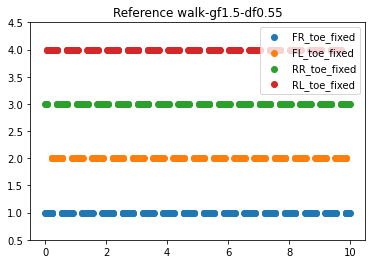

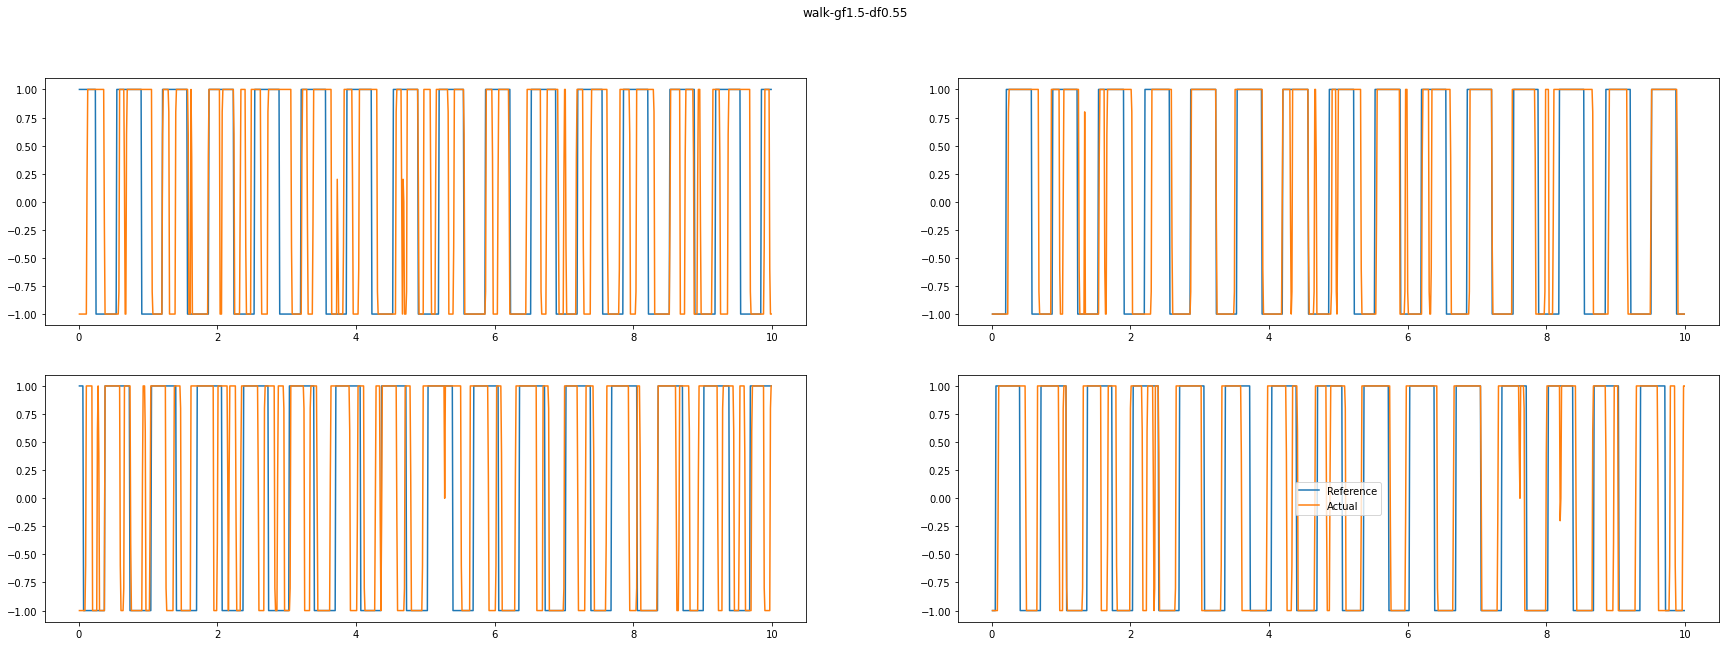

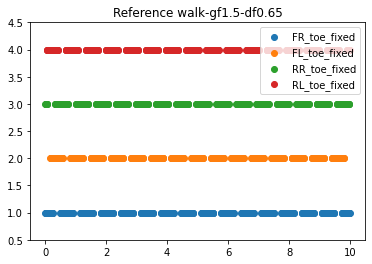

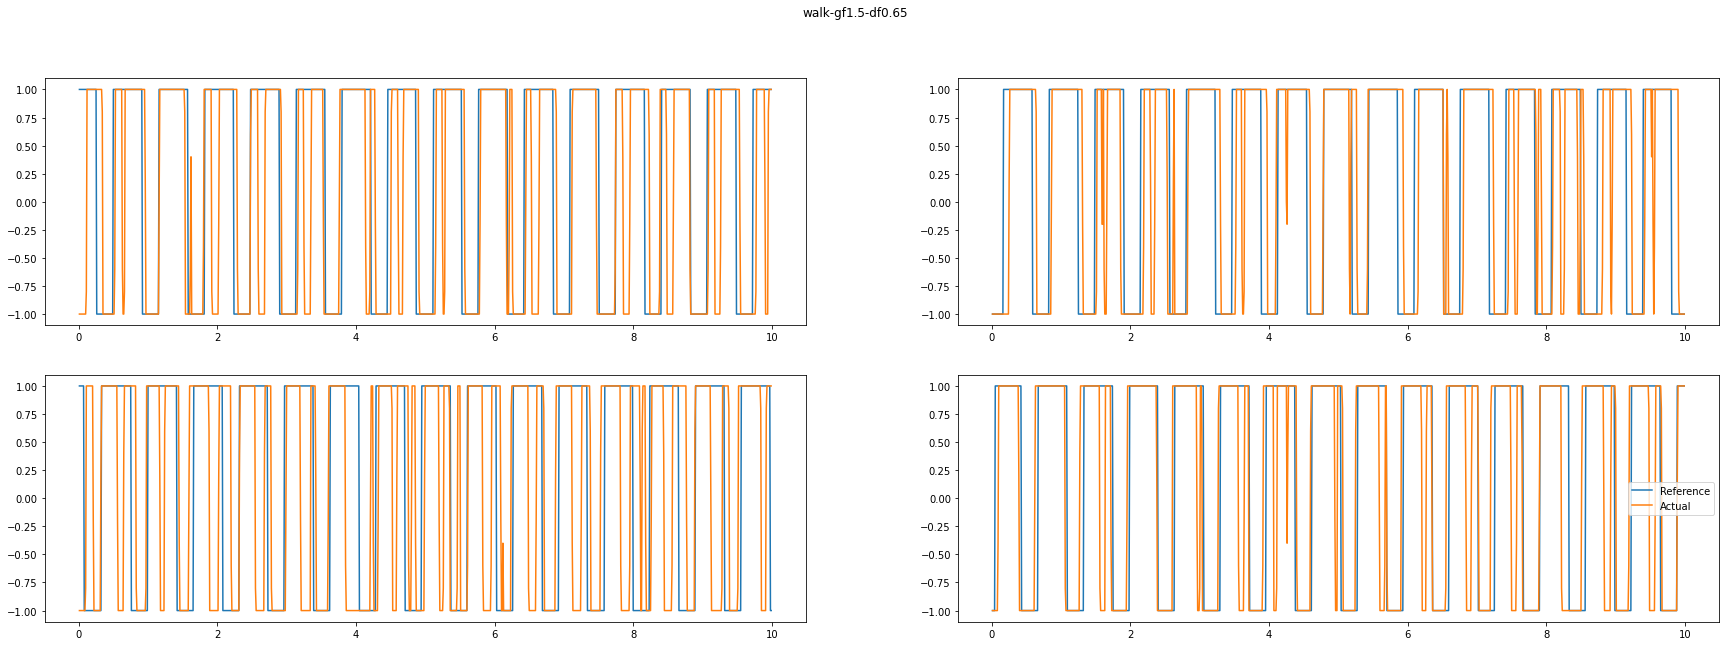

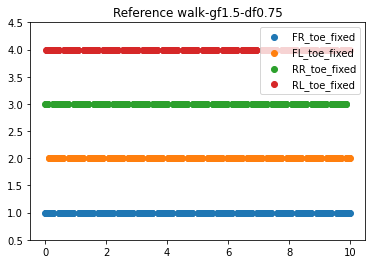

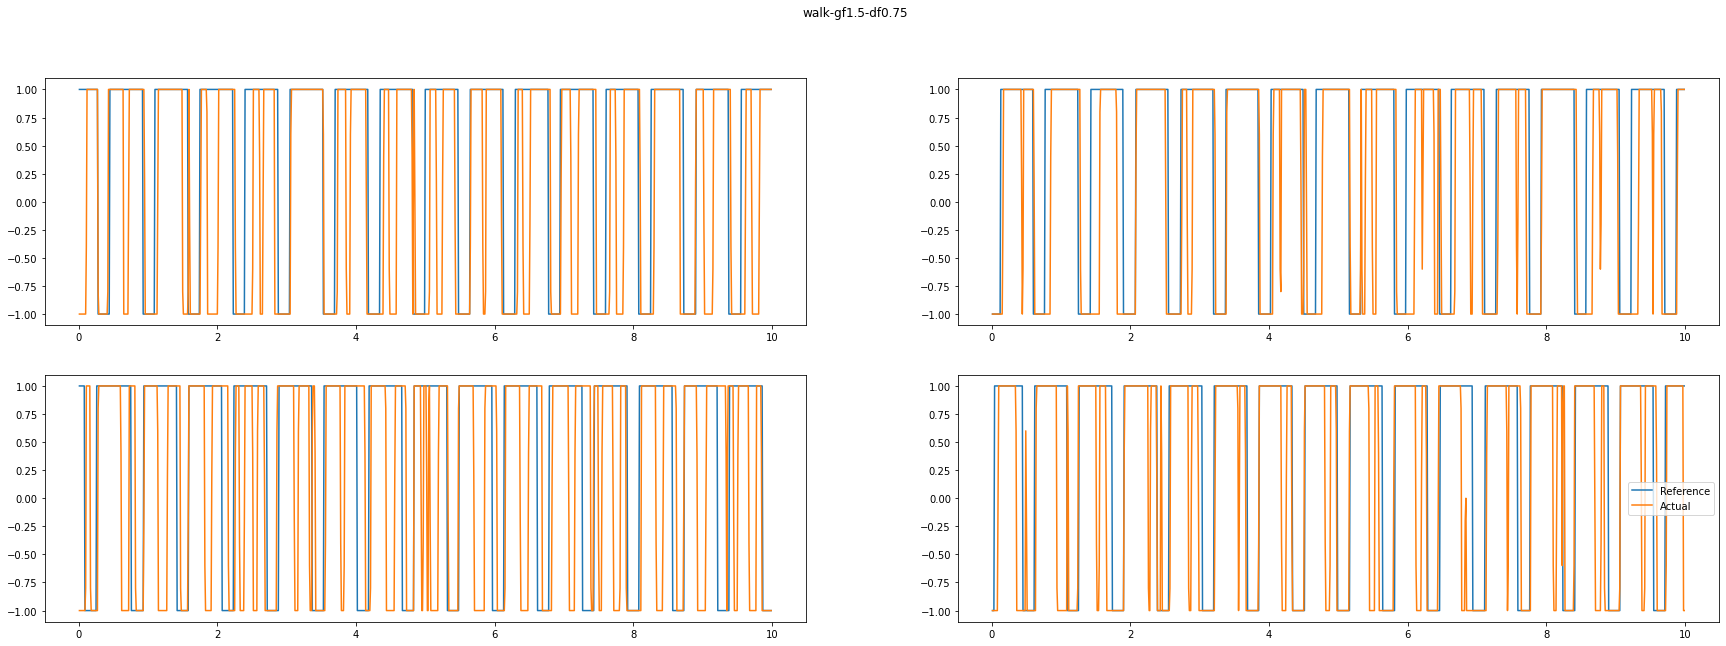

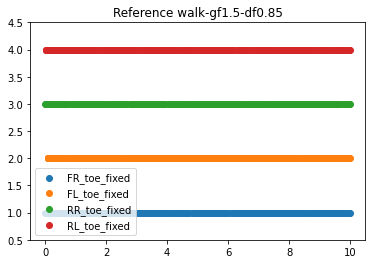

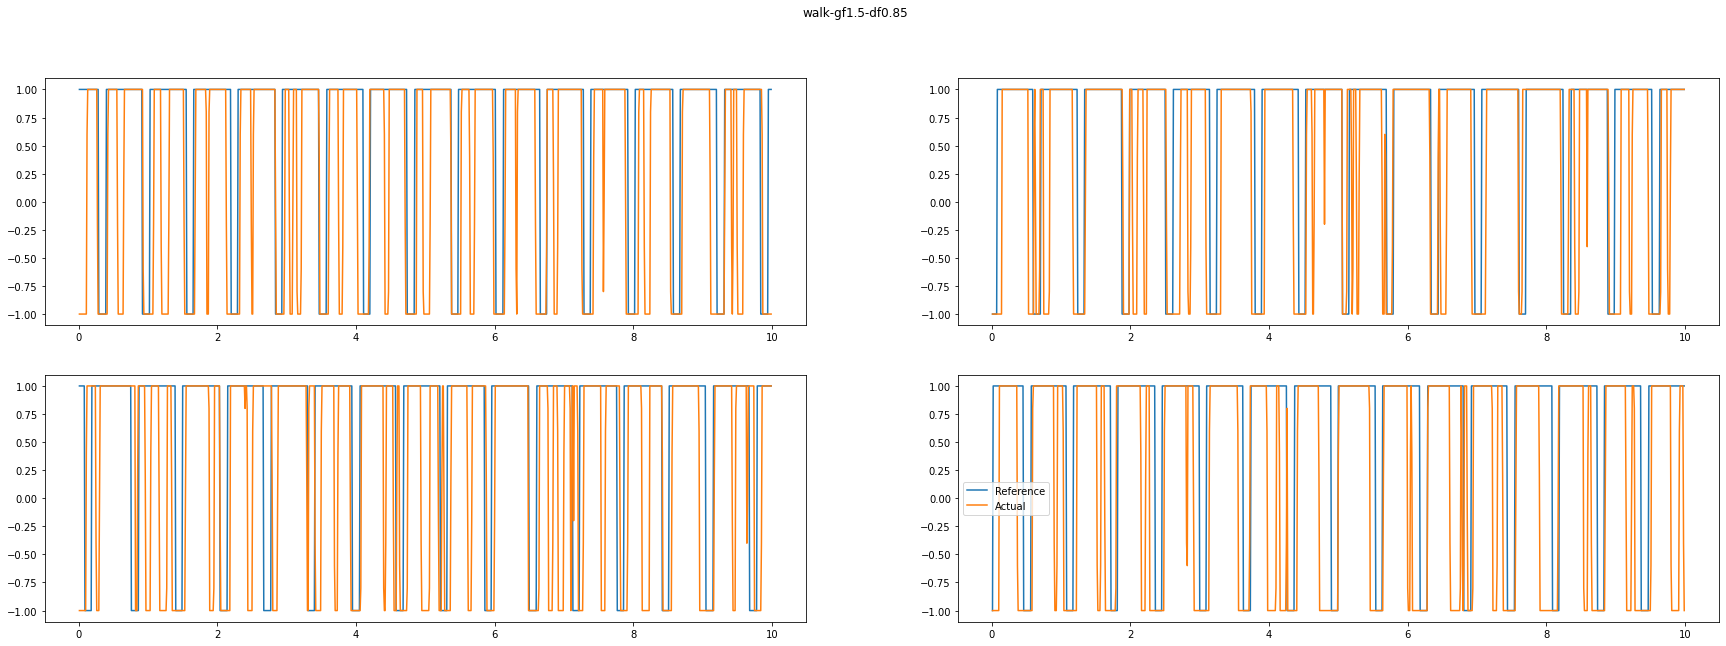

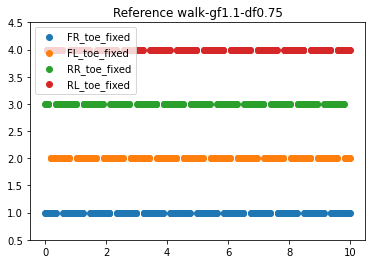

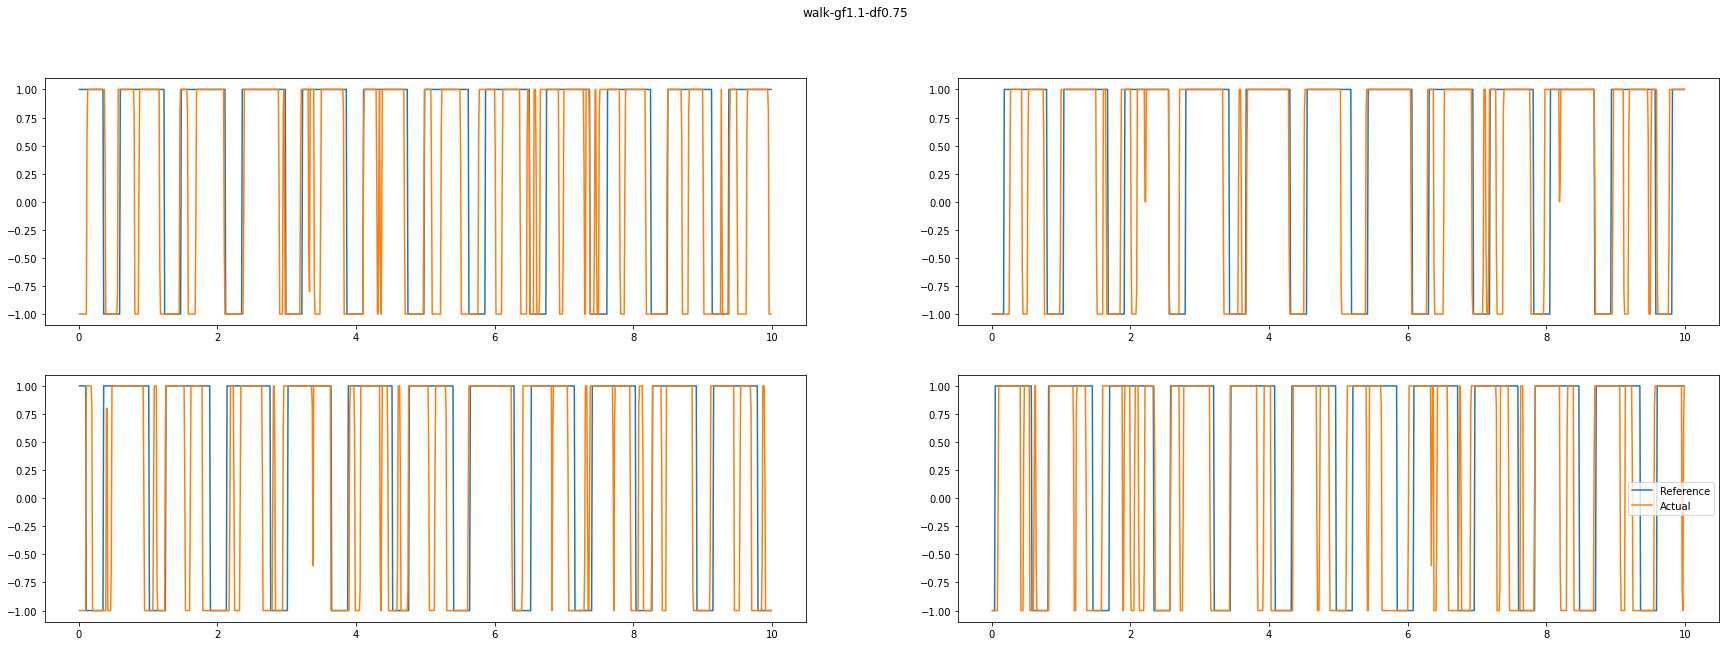

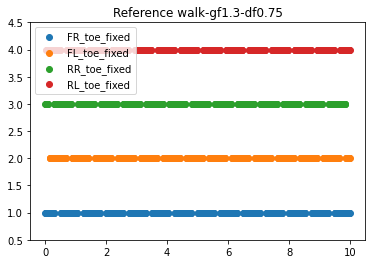

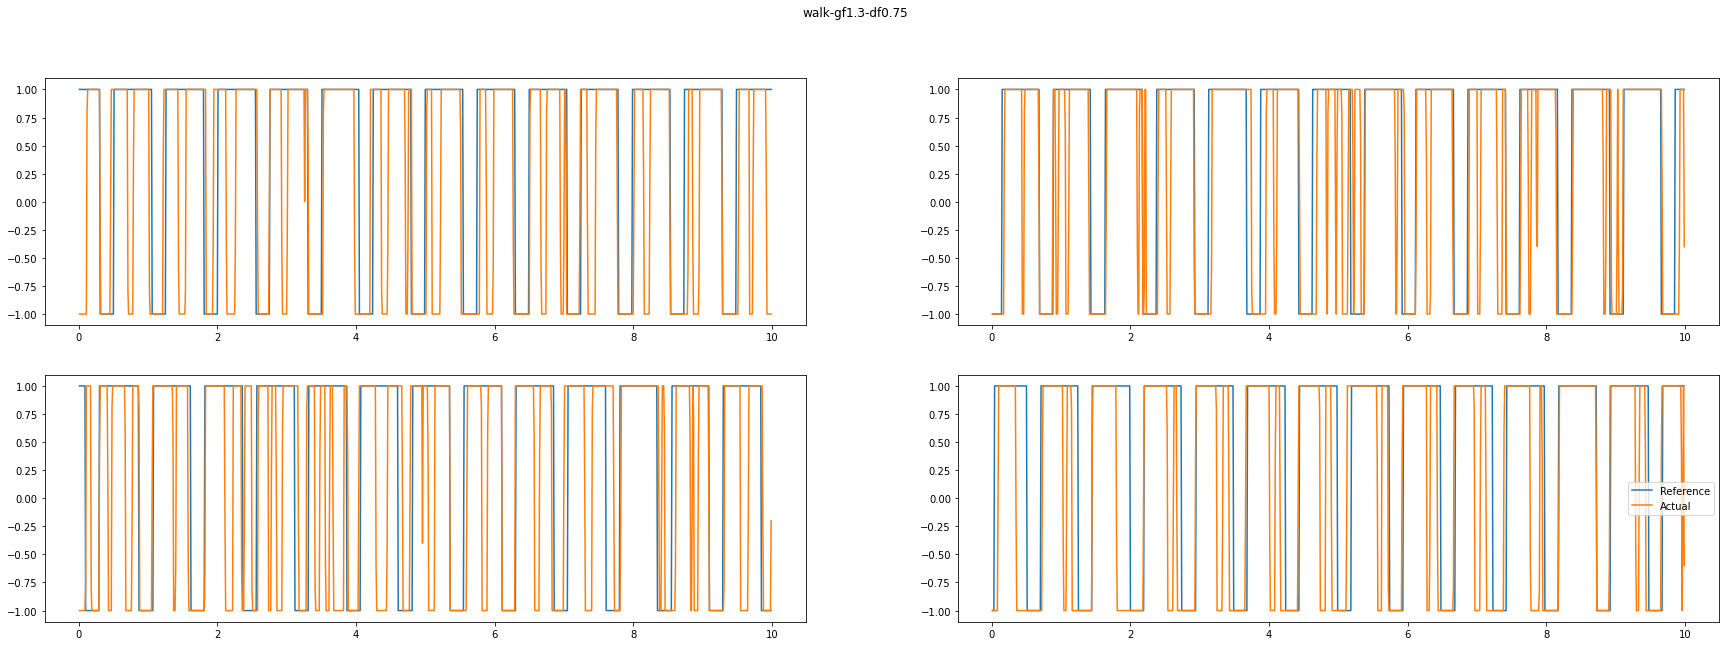

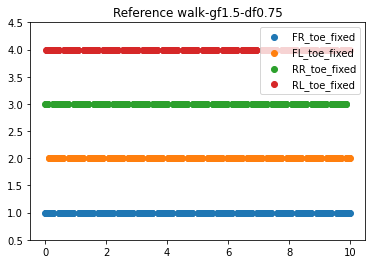

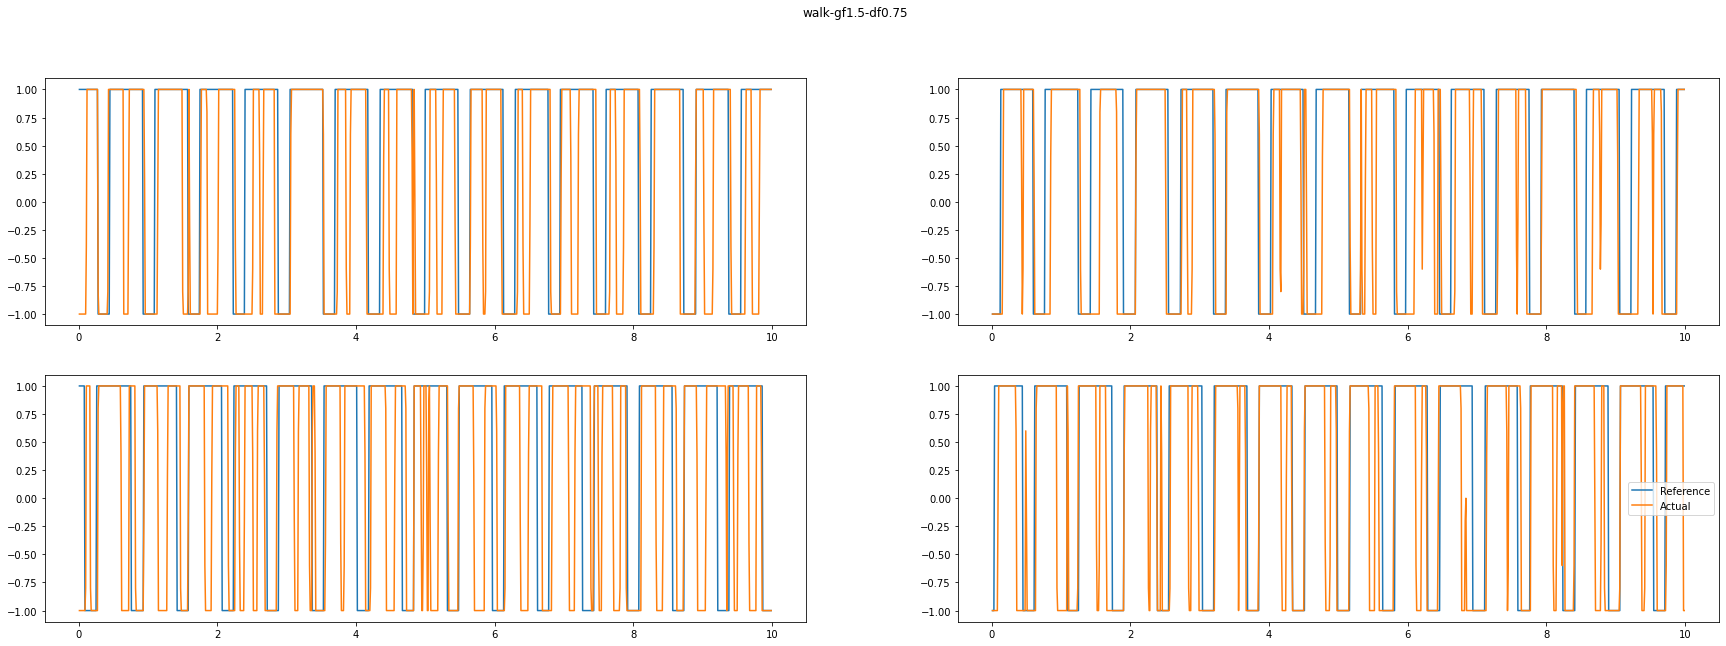

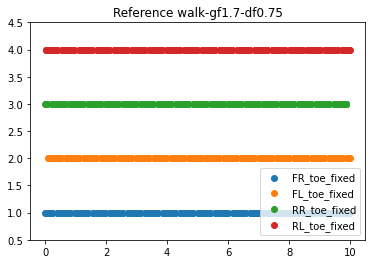

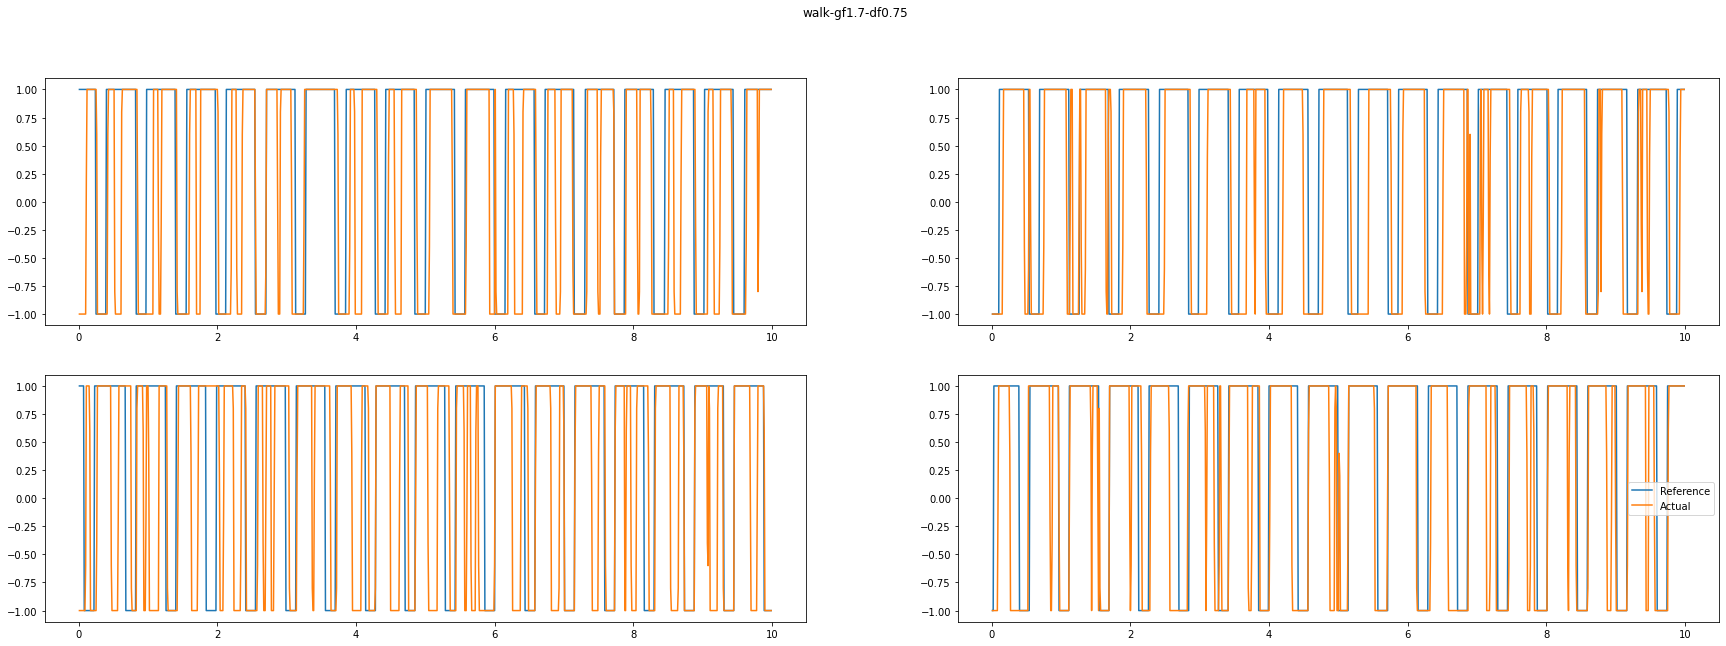

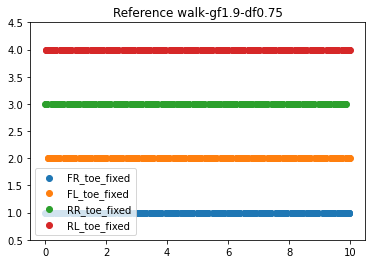

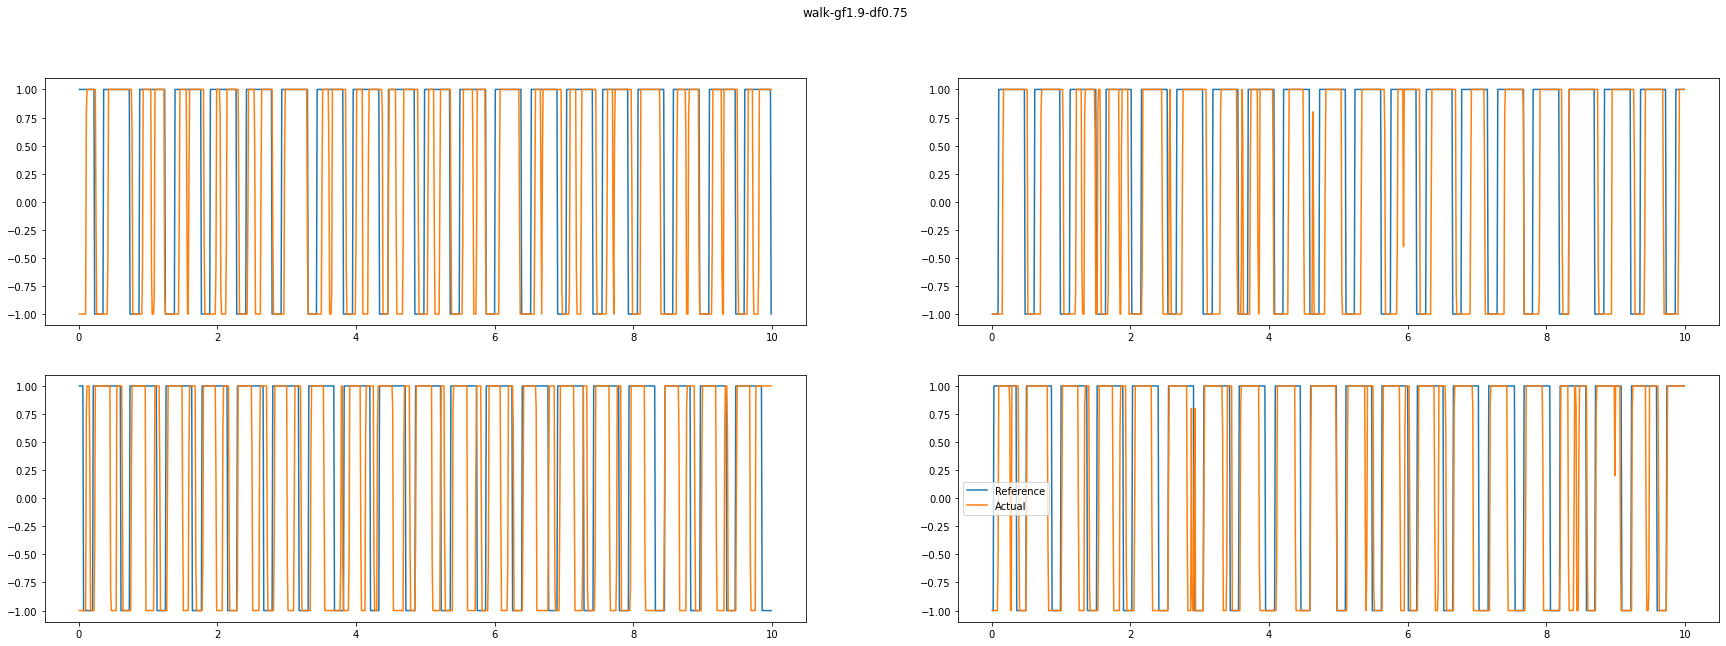

In [37]:
model_dir = project_dir / 'logs' / 'ppo' / 'A1GymEnv-v0_30'

import itertools

DEFAULT_GAIT_FREQUENCY = (1.5,)
ALL_GAIT_FREQUENCIES = (1.1, 1.3, 1.5, 1.7, 1.9)
DEFAULT_DUTY_FACTOR = (0.75,)
ALL_DUTY_FACTORS = (0.55, 0.65, 0.75, 0.85)

settings = itertools.chain(
    itertools.product(DEFAULT_GAIT_FREQUENCY, ALL_DUTY_FACTORS),
    itertools.product(ALL_GAIT_FREQUENCIES, DEFAULT_DUTY_FACTOR)
)


stats_dirs = [
    model_dir / f'walk-gf{gait_freq}-df{duty}' for (gait_freq, duty) in settings
    # model_dir / 'test_var_duty' / f'duty_{duty}' \
    #     for duty in (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85)
]
# stats_dir1 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_1.0Hz_alpha_10.0'
# stats_dir2 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_2.0Hz'

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

NUM_TIMESTEPS = 999

def plot_foot_contact_sequence(stats, stats_dir, normalizer):
    import matplotlib.pyplot as plt 
    
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -20:-16]
    act_foot_contacts = (0.01 - 2 * stats[3]) / 0.01
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    plt.figure()
    plt.title(f"Reference {stats_dir.name}")
    plt.ylim(0.5, 4.5)
    for i in range(4):    
        plt.scatter(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i] * (i+1), label = foot_names[i])
    plt.legend()

    
    fig, ax = plt.subplots(2,2, figsize=(30,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        # ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i], label = 'Reference')
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    plot_foot_contact_sequence(stats, stats_dir, normalizer)
    

FR_toe_fixed 0.3975388192068554 3.324941977379835e-39
FL_toe_fixed 0.7159513619504138 6.425624153485015e-158
RR_toe_fixed 0.33868434482296017 2.9213826470277407e-28
RL_toe_fixed 0.6214505753774796 6.8123721801047025e-108

FR_toe_fixed 0.5829471261508706 4.414719664648059e-92
FL_toe_fixed 0.6089703067206482 1.574206573860442e-102
RR_toe_fixed 0.3006885007231159 2.4156046188000914e-22
RL_toe_fixed 0.6652432013400975 8.631191271279238e-129

FR_toe_fixed 0.5538320043602046 1.8545893290913631e-81
FL_toe_fixed 0.6521485344276842 3.542869234924711e-122
RR_toe_fixed 0.29810399813359795 5.68983591616825e-22
RL_toe_fixed 0.6465407911930781 1.9144911792551136e-119

FR_toe_fixed 0.5586380303301548 3.861287035197242e-83
FL_toe_fixed 0.5567187578245605 1.8261452997605885e-82
RR_toe_fixed 0.3051176350422984 5.452294224186711e-23
RL_toe_fixed 0.4672992104158504 2.1834347665847303e-55

FR_toe_fixed 0.5188744547595715 5.157029465182844e-70
FL_toe_fixed 0.6303555396289335 7.165070330872971e-112
RR_toe_fi

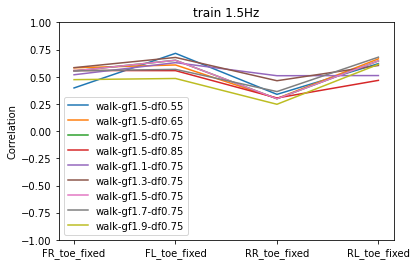

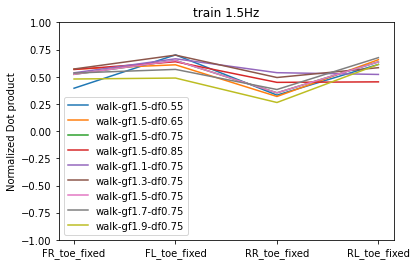

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_correlation(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -20:-16]
    act_foot_contacts = (0.01 - 2 * stats[3]) / 0.01
    corrs = np.zeros(4,)
    for i in range(4):
        corr, p = spearmanr(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        print(foot_names[i], corr, p)
        corrs[i] = corr
    ax.plot(foot_names, corrs, label=label)

def compute_dot_prod(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, -20:-16]
    act_foot_contacts = (0.01 - 2 * stats[3]) / 0.01
    dot_prods = np.zeros(4,)
    for i in range(4):
        dot_prod = np.dot(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        dot_prod = dot_prod / (ref_foot_contacts[:,i] ** 2).sum(axis=0) 
        print(foot_names[i], dot_prod)
        dot_prods[i] = dot_prod
    ax.plot(foot_names, dot_prods, label=label)
    
labels = [sd.name for sd in stats_dirs]

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))

# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_correlation(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Correlation")
ax.legend()

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))
# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_dot_prod(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Normalized Dot product")
ax.legend()